# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier

# Directories

In [2]:
track = 'Long'

data_path = "data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/" + track

particle = 'Electron'
work_path_electron = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/PyROOT_TMVA/kMLP"
netconfig_path_electron = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

particle = 'Proton'
work_path_proton = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/PyROOT_TMVA/kMLP"
netconfig_path_proton = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

particle = 'Pion'
work_path_pion = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/PyROOT_TMVA/kMLP"
netconfig_path_pion = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

particle = 'Muon'
work_path_muon = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/PyROOT_TMVA/kMLP"
netconfig_path_muon = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

particle = 'Kaon'
work_path_kaon = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/PyROOT_TMVA/kMLP"
netconfig_path_kaon = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

particle = 'Ghost'
work_path_ghost = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/PyROOT_TMVA/kMLP"
netconfig_path_ghost = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

# Features

In [3]:
def features(netconfig_path):
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [4]:
features_electron = features(netconfig_path_electron)

features_proton = features(netconfig_path_proton)

features_pion = features(netconfig_path_pion)

features_kaon = features(netconfig_path_kaon)

features_muon = features(netconfig_path_muon)

features_ghost = features(netconfig_path_ghost)

# Classifiers

In [5]:
import ROOT
import array

def reader(work_path, features):
    
    reader = ROOT.TMVA.Reader()
    L = []

    for i in range(0, len(features)):
        var = array.array('f',[0])
        reader.AddVariable(features[i],var)
        L.append(var)


    reader.BookMVA("MLP",work_path + "/weights/TMVAClassification_MLP.weights.xml")
    
    return reader, L

In [6]:
# Read classifier
reader_electron, L_electron = reader(work_path_electron, features_electron)

reader_proton, L_proton = reader(work_path_proton, features_proton)

reader_pion, L_pion = reader(work_path_pion, features_pion)

reader_kaon, L_kaon = reader(work_path_kaon, features_kaon)

reader_muon, L_muon = reader(work_path_muon, features_muon)

reader_ghost, L_ghost = reader(work_path_ghost, features_ghost)

# Read eval data

In [7]:
filename = data_path + "/data_eval.csv"

data_eval = pandas.read_csv(filename)

# Labels

In [8]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}


pdg = particle_pdg_codes['Electron']
labels_electron = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Proton']
labels_proton = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Pion']
labels_pion = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Muon']
labels_muon = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Kaon']
labels_kaon = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Ghost']
labels_ghost = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

# Probabilities

In [9]:
def predict_proba(data_eval, features, reader, L):

    test = numpy.array(data_eval[features+['MCParticleType']].values.tolist())

    probas = []
    for i in range(0, len(test)):
        for k in range(0, len(L)):
            L[k][0] = test[i,:][k]
        probas.append(reader.EvaluateMVA("MLP"))
    
    probas = numpy.array(probas)
    eval_proba = numpy.concatenate(((1 - probas).reshape(-1, 1), probas.reshape(-1, 1)), axis=1)

    return eval_proba

In [10]:
proba_electron = predict_proba(data_eval, features_electron, reader_electron, L_electron)

proba_proton = predict_proba(data_eval, features_proton, reader_proton, L_proton)

proba_pion = predict_proba(data_eval, features_pion, reader_pion, L_pion)

proba_muon = predict_proba(data_eval, features_muon, reader_muon, L_muon)

proba_kaon = predict_proba(data_eval, features_kaon, reader_kaon, L_kaon)

proba_ghost = predict_proba(data_eval, features_ghost, reader_ghost, L_ghost)

In [11]:
probas_all = (proba_electron[:, [1]], 
              proba_proton[:, [1]], 
              proba_pion[:, [1]], 
              proba_muon[:, [1]], 
              proba_kaon[:, [1]], 
              proba_ghost[:, [1]])

proba_overall = numpy.concatenate(probas_all, axis=1)
proba_overall = proba_overall/proba_overall.sum(axis=1, keepdims=True)

# Roc aucs

In [12]:
roc_auc_electron = roc_auc_score(labels_electron, proba_electron[:, 1])
fpr_electron, tpr_electron, _ = roc_curve(labels_electron, proba_electron[:, 1])

roc_auc_proton = roc_auc_score(labels_proton, proba_proton[:, 1])
fpr_proton, tpr_proton, _ = roc_curve(labels_proton, proba_proton[:, 1])

roc_auc_pion = roc_auc_score(labels_pion, proba_pion[:, 1])
fpr_pion, tpr_pion, _ = roc_curve(labels_pion, proba_pion[:, 1])

roc_auc_muon = roc_auc_score(labels_muon, proba_muon[:, 1])
fpr_muon, tpr_muon, _ = roc_curve(labels_muon, proba_muon[:, 1])

roc_auc_kaon = roc_auc_score(labels_kaon, proba_kaon[:, 1])
fpr_kaon, tpr_kaon, _ = roc_curve(labels_kaon, proba_kaon[:, 1])

roc_auc_ghost = roc_auc_score(labels_ghost, proba_ghost[:, 1])
fpr_ghost, tpr_ghost, _ = roc_curve(labels_ghost, proba_ghost[:, 1])

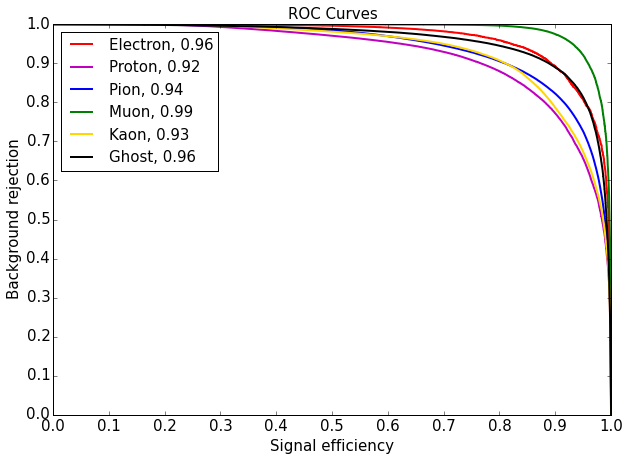

In [13]:
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
colors = ['k', 'r', 'g', 'b', 'gold', 'm']

plt.figure(figsize=(10,7))
plt.plot(tpr_electron, 1.-fpr_electron, label='Electron, %.2f' % roc_auc_electron, color='r', linewidth=2)
plt.plot(tpr_proton, 1.-fpr_proton, label='Proton, %.2f' % roc_auc_proton, color='m', linewidth=2)
plt.plot(tpr_pion, 1.-fpr_pion, label='Pion, %.2f' % roc_auc_pion, color='b', linewidth=2)
plt.plot(tpr_muon, 1.-fpr_muon, label='Muon, %.2f' % roc_auc_muon, color='g', linewidth=2)
plt.plot(tpr_kaon, 1.-fpr_kaon, label='Kaon, %.2f' % roc_auc_kaon, color='gold', linewidth=2)
plt.plot(tpr_ghost, 1.-fpr_ghost, label='Ghost, %.2f' % roc_auc_ghost, color='k', linewidth=2)
plt.title("ROC Curves", size=15)
plt.xlabel("Signal efficiency", size=15)
plt.ylabel("Background rejection", size=15)
plt.legend(loc='best',prop={'size':15})
plt.xticks(numpy.arange(0, 1.01, 0.1), size=15)
plt.yticks(numpy.arange(0, 1.01, 0.1), size=15)


plt.savefig(work_path_electron + "/overall_roc_auc.png")
plt.savefig(work_path_proton + "/overall_roc_auc.png")
plt.savefig(work_path_pion + "/overall_roc_auc.png")
plt.savefig(work_path_muon + "/overall_roc_auc.png")
plt.savefig(work_path_kaon + "/overall_roc_auc.png")
plt.savefig(work_path_ghost + "/overall_roc_auc.png")

plt.show()

# Roc matrix

In [14]:
roc_auc_electron = roc_auc_score(labels_electron, proba_electron[:, 1])

probas_list = [proba_electron, proba_proton, proba_pion, proba_muon, proba_kaon, proba_ghost]
labels_list = [labels_electron, labels_proton, labels_pion, labels_muon, labels_kaon, labels_ghost]

roc_matrics = numpy.ones((6,6))

for i in range(0, 6):
    for j in range(0, 6):
        if i==j:
            continue
        sel = ((labels_list[i] != 0) + (labels_list[j] != 0)) * 1.
        roc_auc = roc_auc_score(labels_list[i], proba_overall[:, i]/proba_overall[:, j], sample_weight=sel)
        roc_matrics[i,j] = roc_auc

In [15]:
particles = ['Electron', 'Proton', 'Pion', 'Muon', 'Kaon', 'Ghost']

matrix = pandas.DataFrame(columns=['Particle'] + particles)
matrix['Particle'] = particles
matrix['Electron'] = roc_matrics[0, :]
matrix['Proton'] = roc_matrics[1, :]
matrix['Pion'] = roc_matrics[2, :]
matrix['Muon'] = roc_matrics[3, :]
matrix['Kaon'] = roc_matrics[4, :]
matrix['Ghost'] = roc_matrics[5, :]

matrix.to_csv(work_path_electron + "/class_vs_class_roc_auc_matrix.csv")
matrix.to_csv(work_path_proton + "/class_vs_class_roc_auc_matrix.csv")
matrix.to_csv(work_path_pion + "/class_vs_class_roc_auc_matrix.csv")
matrix.to_csv(work_path_muon + "/class_vs_class_roc_auc_matrix.csv")
matrix.to_csv(work_path_kaon + "/class_vs_class_roc_auc_matrix.csv")
matrix.to_csv(work_path_ghost + "/class_vs_class_roc_auc_matrix.csv")

matrix

,Particle,Electron,Proton,Pion,Muon,Kaon,Ghost
0,Electron,1.000000,0.985355,0.977771,0.996391,0.984852,0.953952
1,Proton,0.985350,1.000000,0.954159,0.994473,0.787170,0.975513
2,Pion,0.977451,0.954160,1.000000,0.987573,0.954936,0.961073
3,Muon,0.996388,0.994473,0.987599,1.000000,0.993378,0.992115
4,Kaon,0.984885,0.787170,0.954936,0.993378,1.000000,0.977715
5,Ghost,0.953951,0.975513,0.961073,0.992115,0.977715,1.000000


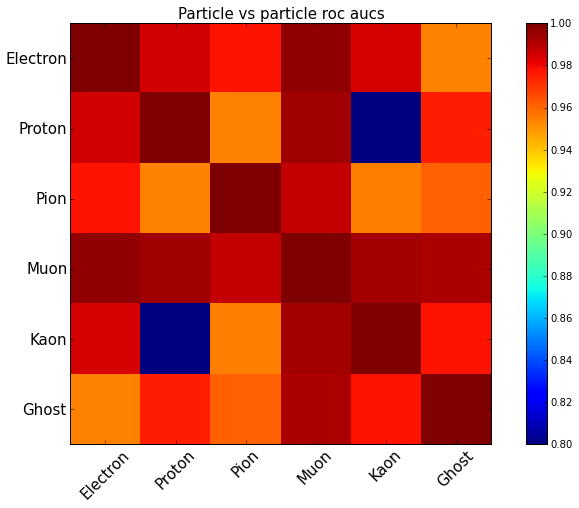

In [16]:


plt.figure(figsize=(10,7))
plt.imshow(roc_matrics, interpolation='nearest')
tick_marks = numpy.arange(len(particles))
plt.xticks(tick_marks, particles, rotation=45, size=15)
plt.yticks(tick_marks, particles, size=15)
plt.clim([0.8,1])
plt.colorbar()
plt.tight_layout()
plt.title('Particle vs particle roc aucs', size=15)


plt.savefig(work_path_electron + "/class_vs_class_roc_auc_matrix.png")
plt.savefig(work_path_proton + "/class_vs_class_roc_auc_matrix.png")
plt.savefig(work_path_pion + "/class_vs_class_roc_auc_matrix.png")
plt.savefig(work_path_muon + "/class_vs_class_roc_auc_matrix.png")
plt.savefig(work_path_kaon + "/class_vs_class_roc_auc_matrix.png")
plt.savefig(work_path_ghost + "/class_vs_class_roc_auc_matrix.png")
plt.show()

# Flatness

In [20]:
import os, sys
sys.path.append('../python')

from utils import compute_cvm

In [21]:
GeV = 1000
limits = {"TrackP": [100*GeV, 0],
          "TrackPt": [10*GeV, 0],
          "CombDLLe": [20, -20],
          "CombDLLmu": [20, -20],
          "CombDLLpi": [150, -150],
          "CombDLLk": [150, -150],
          "CombDLLp": [150, -150] }

In [22]:
track_p = data_eval.TrackP.values
sel_p = (track_p >= limits["TrackP"][1]) * (track_p < limits["TrackP"][0])

track_pt = data_eval.TrackPt.values
sel_pt = (track_pt >= limits["TrackPt"][1]) * (track_pt < limits["TrackPt"][0])

In [67]:
flatness = pandas.DataFrame(columns=['Particle', 'TrackP', 'TrackPt'])
flatness['Particle'] = particles

sel_electron_p = sel_p * (labels_electron == 1)
sel_electron_pt = sel_pt * (labels_electron == 1)
cvm_electron_p = compute_cvm(proba_electron[sel_electron_p, 1], track_p[sel_electron_p])
cvm_electron_pt = compute_cvm(proba_electron[sel_electron_pt, 1], track_pt[sel_electron_pt])

sel_proton_p = sel_p * (labels_proton == 1)
sel_proton_pt = sel_pt * (labels_proton == 1)
cvm_proton_p = compute_cvm(proba_proton[sel_proton_p, 1], track_p[sel_proton_p])
cvm_proton_pt = compute_cvm(proba_proton[sel_proton_pt, 1], track_pt[sel_proton_pt])

sel_pion_p = sel_p * (labels_pion == 1)
sel_pion_pt = sel_pt * (labels_pion == 1)
cvm_pion_p = compute_cvm(proba_pion[sel_pion_p, 1], track_p[sel_pion_p])
cvm_pion_pt = compute_cvm(proba_pion[sel_pion_pt, 1], track_pt[sel_pion_pt])

sel_muon_p = sel_p * (labels_muon == 1)
sel_muon_pt = sel_pt * (labels_muon == 1)
cvm_muon_p = compute_cvm(proba_muon[sel_muon_p, 1], track_p[sel_muon_p])
cvm_muon_pt = compute_cvm(proba_muon[sel_muon_pt, 1], track_pt[sel_muon_pt])

sel_kaon_p = sel_p * (labels_kaon == 1)
sel_kaon_pt = sel_pt * (labels_kaon == 1)
cvm_kaon_p = compute_cvm(proba_kaon[sel_kaon_p, 1], track_p[sel_kaon_p])
cvm_kaon_pt = compute_cvm(proba_kaon[sel_kaon_pt, 1], track_pt[sel_kaon_pt])

sel_ghost_p = sel_p * (labels_ghost == 1)
sel_ghost_pt = sel_pt * (labels_ghost == 1)
cvm_ghost_p = compute_cvm(proba_ghost[sel_ghost_p, 1], track_p[sel_ghost_p])
cvm_ghost_pt = compute_cvm(proba_ghost[sel_ghost_pt, 1], track_pt[sel_ghost_pt])

flatness['TrackP'] = [cvm_electron_p, cvm_proton_p, cvm_pion_p, cvm_muon_p, cvm_kaon_p, cvm_ghost_p]
flatness['TrackPt'] = [cvm_electron_pt, cvm_proton_pt, cvm_pion_pt, cvm_muon_pt, cvm_kaon_pt, cvm_ghost_pt]


flatness.to_csv(work_path_electron + "/flatness.csv")
flatness.to_csv(work_path_proton + "/flatness.csv")
flatness.to_csv(work_path_pion + "/flatness.csv")
flatness.to_csv(work_path_muon + "/flatness.csv")
flatness.to_csv(work_path_kaon + "/flatness.csv")
flatness.to_csv(work_path_ghost + "/flatness.csv")

In [68]:
flatness

,Particle,TrackP,TrackPt
0,Electron,0.006546,0.016579
1,Proton,0.034632,0.044571
2,Pion,0.016512,0.013729
3,Muon,0.020388,0.044991
4,Kaon,0.043074,0.036657
5,Ghost,0.006591,0.014187


# Efficiency curves

In [186]:
from rep.utils import get_efficiencies
from rep.plotting import ErrorPlot

def flatness_p_figure(proba, track_p, sel_p, track, particle, work_path):

    thresholds = numpy.percentile(proba[sel_p, 1], 100 - numpy.array([5, 20, 40, 60, 80]))

    eff = get_efficiencies(proba[sel_p, 1], 
                           track_p[sel_p], 
                           bins_number=30, 
                           errors=True, 
                           ignored_sideband=0, 
                           thresholds=thresholds)
    
    for i in thresholds:
        eff[i] = (eff[i][0], 100. * eff[i][1], 100. * eff[i][2], eff[i][3])
    
    plot_fig = ErrorPlot(eff)
    plot_fig.ylim = (0, 100)

    plot_fig.plot(new_plot=True, figsize=(10,7))
    plt.legend(['Eff = 5 %', 'Eff = 20 %', 'Eff = 40 %', 'Eff = 60 %', 'Eff = 80 %'], loc='best',prop={'size':15})
    plt.xlabel(track + ' ' + particle + ' Momentum / MeV/c', size=15)
    plt.xticks(size=15)
    plt.ylabel('Efficiency / %', size=15)
    plt.yticks(size=15)
    plt.title('Flatness_SignalMVAEffVTrackP_' + track + ' ' + particle, size=15)
    plt.savefig(work_path + "/" + 'Flatness_SignalMVAEffVTrackP_' + track + '_' + particle + ".png")

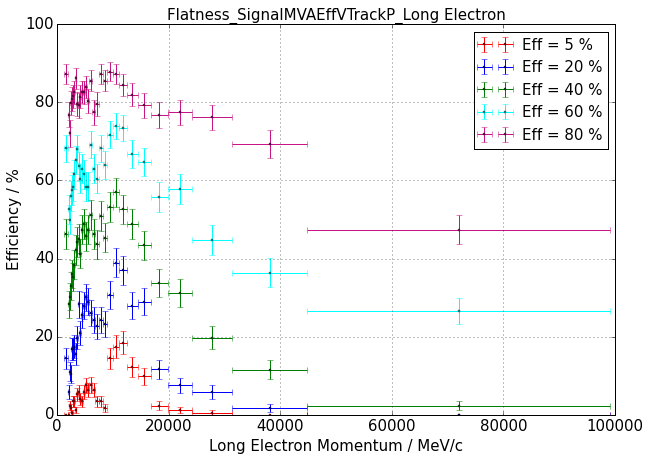

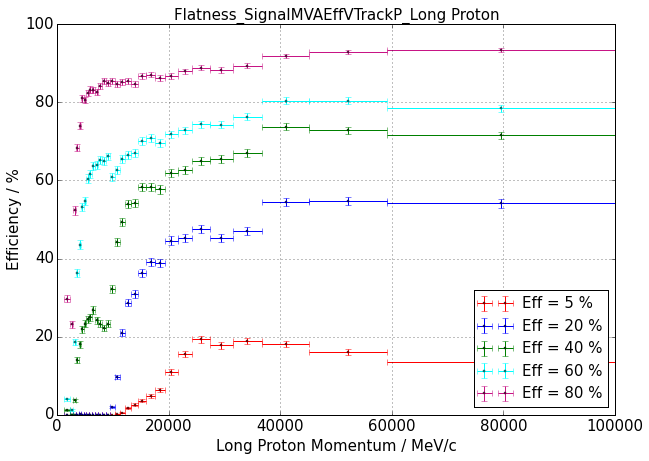

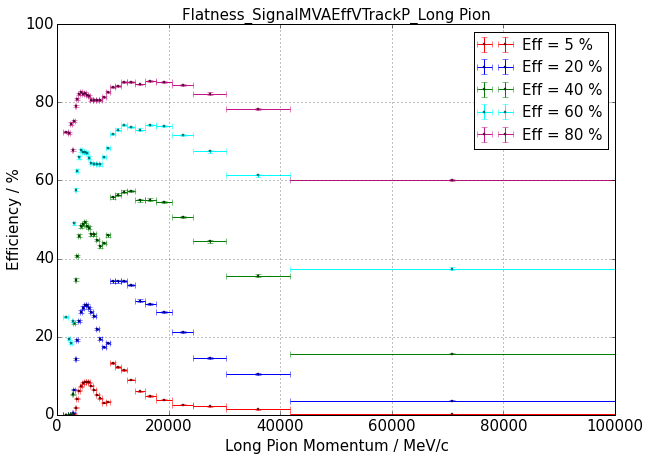

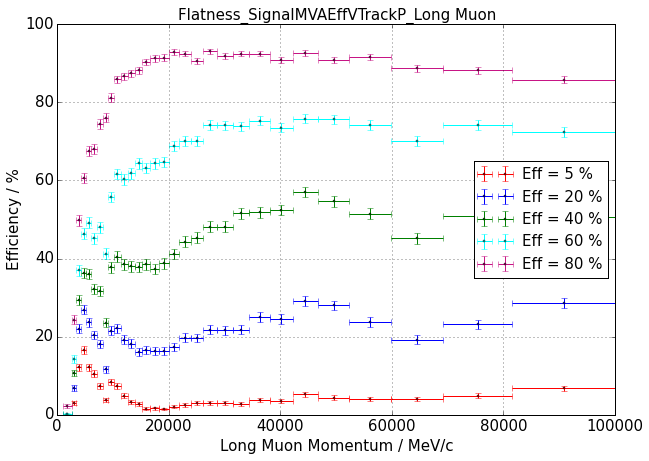

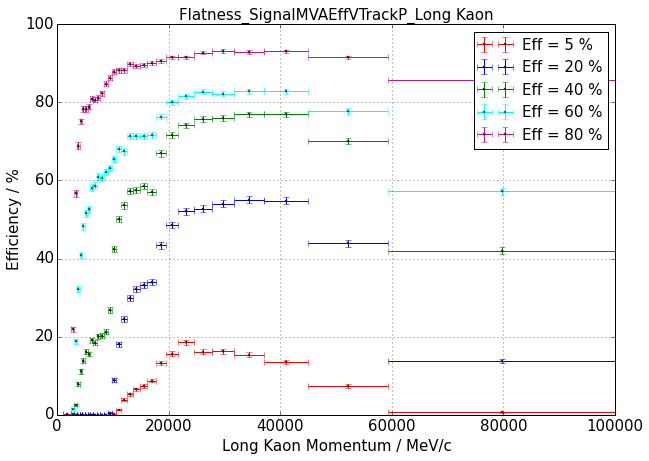

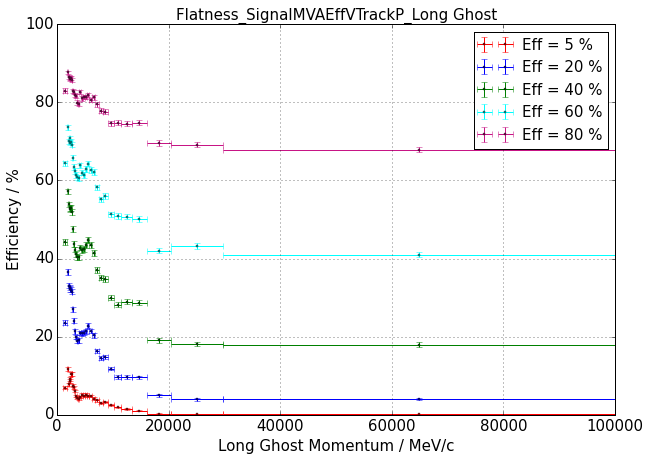

In [187]:
flatness_p_figure(proba_electron, track_p, sel_electron_p, 'Long', 'Electron', work_path_electron)
flatness_p_figure(proba_proton, track_p, sel_proton_p, 'Long', 'Proton', work_path_proton)
flatness_p_figure(proba_pion, track_p, sel_pion_p, 'Long', 'Pion', work_path_pion)
flatness_p_figure(proba_muon, track_p, sel_muon_p, 'Long', 'Muon', work_path_muon)
flatness_p_figure(proba_kaon, track_p, sel_kaon_p, 'Long', 'Kaon', work_path_kaon)
flatness_p_figure(proba_ghost, track_p, sel_ghost_p, 'Long', 'Ghost', work_path_ghost)

In [184]:
from rep.utils import get_efficiencies
from rep.plotting import ErrorPlot

def flatness_pt_figure(proba, track_pt, sel_pt, track, particle, work_path):

    thresholds = numpy.percentile(proba[sel_pt, 1], 100 - numpy.array([5, 20, 40, 60, 80]))

    eff = get_efficiencies(proba[sel_pt, 1], 
                           track_pt[sel_pt], 
                           bins_number=30, 
                           errors=True, 
                           ignored_sideband=0, 
                           thresholds=thresholds)
    for i in thresholds:
        eff[i] = (eff[i][0], 100. * eff[i][1], 100. * eff[i][2], eff[i][3])
    
    plot_fig = ErrorPlot(eff)
    plot_fig.ylim = (0, 100)

    plot_fig.plot(new_plot=True, figsize=(10,7))
    plt.legend(['Eff = 5 %', 'Eff = 20 %', 'Eff = 40 %', 'Eff = 60 %', 'Eff = 80 %'], loc='best',prop={'size':15})
    plt.xlabel(track + ' ' + particle + ' Transverse Momentum / MeV/c', size=15)
    plt.xticks(size=15)
    plt.ylabel('Efficiency / %', size=15)
    plt.yticks(size=15)
    plt.title('Flatness_SignalMVAEffVTrackPt_' + track + ' ' + particle, size=15)
    plt.savefig(work_path + "/" + 'Flatness_SignalMVAEffVTrackPt_' + track + '_' + particle + ".png")

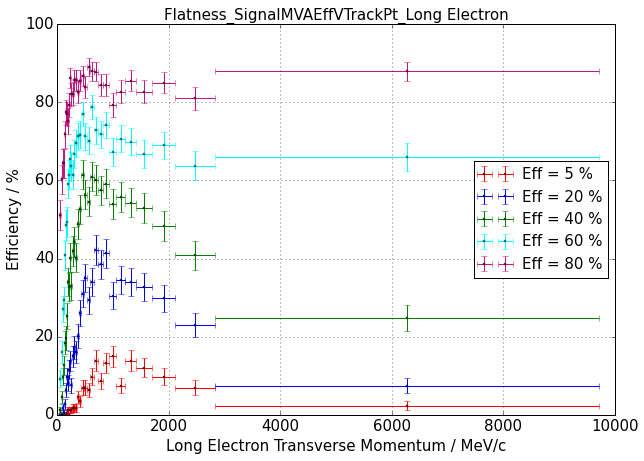

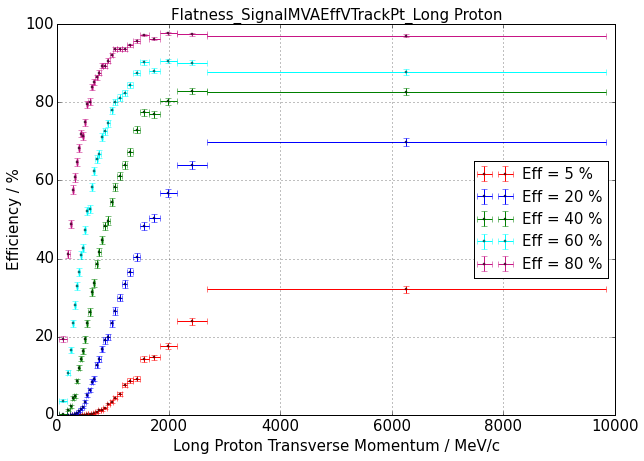

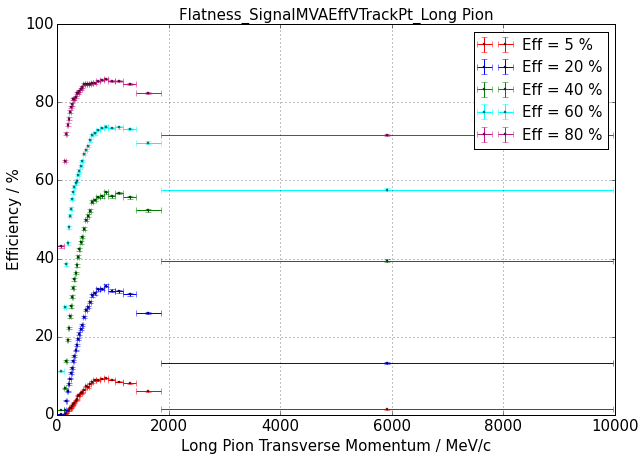

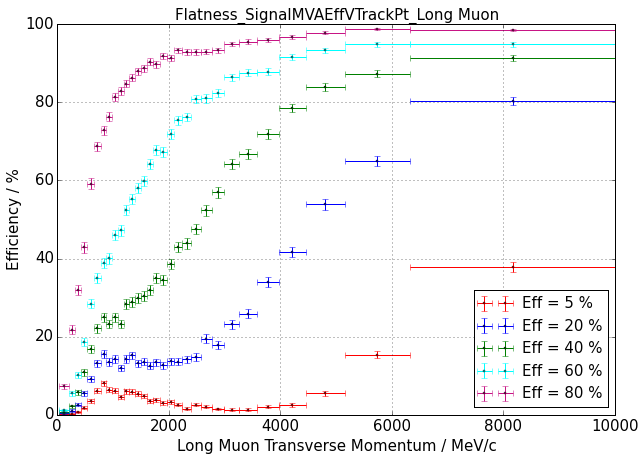

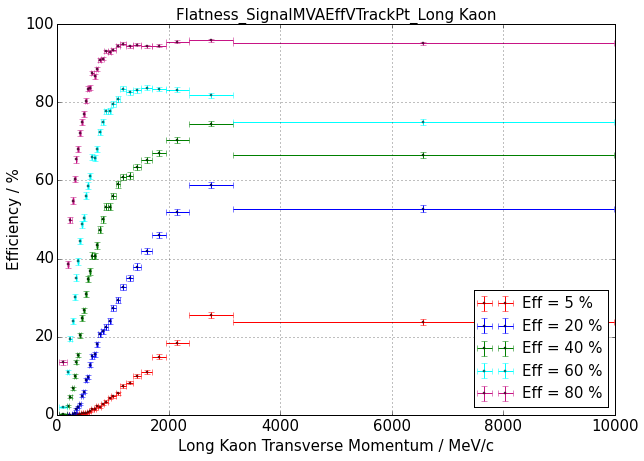

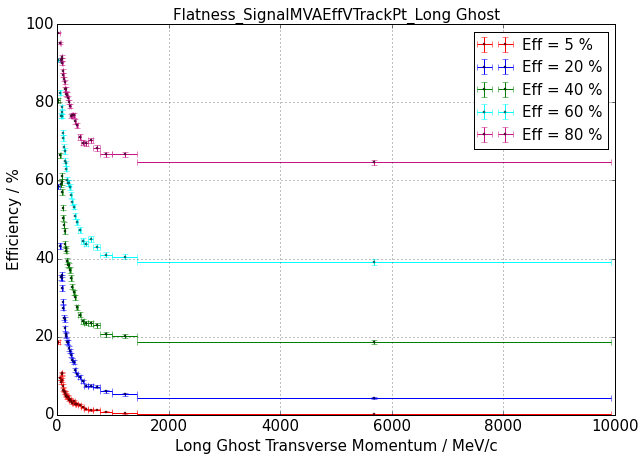

In [185]:
flatness_pt_figure(proba_electron, track_pt, sel_electron_pt, 'Long', 'Electron', work_path_electron)
flatness_pt_figure(proba_proton, track_pt, sel_proton_pt, 'Long', 'Proton', work_path_proton)
flatness_pt_figure(proba_pion, track_pt, sel_pion_pt, 'Long', 'Pion', work_path_pion)
flatness_pt_figure(proba_muon, track_pt, sel_muon_pt, 'Long', 'Muon', work_path_muon)
flatness_pt_figure(proba_kaon, track_pt, sel_kaon_pt, 'Long', 'Kaon', work_path_kaon)
flatness_pt_figure(proba_ghost, track_pt, sel_ghost_pt, 'Long', 'Ghost', work_path_ghost)

In [179]:
proba_electron

array([[  9.99931856e-01,   6.81440613e-05],
       [  9.97828486e-01,   2.17151401e-03],
       [  9.99999982e-01,   1.77847988e-08],
       ..., 
       [  9.91709421e-01,   8.29057874e-03],
       [  9.61983474e-01,   3.80165256e-02],
       [  9.96550279e-01,   3.44972121e-03]])

In [180]:
labels_electron

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [181]:
thresholds

array([ 0.00215197,  0.01488133,  0.06434044,  0.24123746,  0.66222098])